# Visualization of the uncertainty maps

In [19]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Union

from assets.dicom_utils import resample_to_reference
from assets.uncertainty_quantification import apply_percentile_threshold
from assets.image_operations import apply_gaussian_blur_3d


roots = {
    'kspace':            Path('/scratch/p290820/datasets/003_umcg_pst_ksps'),
    'reader_study':      Path('/scratch/hb-pca-rad/projects/03_reader_set_v2'),
    'reader_study_segs': Path('/scratch/hb-pca-rad/projects/03_reader_set_v2/segs'),
    'R3_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    'R6_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x"),
    'db_fpath_old':      Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db'),                  # References an OLDER version of the databases where the info could also just be fine that we are looking for
    'db_fpath_new':      Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db'),    # References the LATEST version of the databases where the info could also just be fine that we are looking for
    'figures_gaussian':  Path('/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/figures'),
}

debug                = True
do_adaptive_clipping = True
acc_factors          = [3, 6] # Define the set of acceleration factors we care about.
decimals             = 4      # Number of decimals to round to

# All patient IDs to consider for Uncertainty Quantification
pat_ids = [
        # '0003_ANON5046358',
        # '0004_ANON9616598',
        # '0005_ANON8290811',
        # '0006_ANON2379607',
        '0007_ANON1586301',
        '0008_ANON8890538',
        # '0010_ANON7748752',
        # '0011_ANON1102778',
        # '0012_ANON4982869',
        # '0013_ANON7362087',
        # '0014_ANON3951049',
        # '0015_ANON9844606',
        # '0018_ANON9843837',
        # '0019_ANON7657657',
        # '0020_ANON1562419',
        # '0021_ANON4277586',
        # '0023_ANON6964611',
        # '0024_ANON7992094',
        # '0026_ANON3620419',
        # '0027_ANON9724912',
        # '0028_ANON3394777',
        # '0029_ANON7189994',
        # '0030_ANON3397001',
        # '0031_ANON9141039',
        # '0032_ANON7649583',
        # '0033_ANON9728185',
        # '0035_ANON3474225',
        # '0036_ANON0282755',
        # '0037_ANON0369080',
        # '0039_ANON0604912',
        # '0042_ANON9423619',
        # '0043_ANON7041133',
        # '0044_ANON8232550',
        # '0045_ANON2563804',
        # '0047_ANON3613611',
        # '0048_ANON6365688',
        # '0049_ANON9783006',
        # '0051_ANON1327674',
        # '0052_ANON9710044',
        # '0053_ANON5517301',
        # '0055_ANON3357872',
        # '0056_ANON2124757',
        # '0057_ANON1070291',
        # '0058_ANON9719981',
        # '0059_ANON7955208',
        # '0061_ANON7642254',
        # '0062_ANON0319974',
        # '0063_ANON9972960',
        # '0064_ANON0282398',
        # '0067_ANON0913099',
        # '0068_ANON7978458',
        # '0069_ANON9840567',
        # '0070_ANON5223499',
        # '0071_ANON9806291',
        # '0073_ANON5954143',
        # '0075_ANON5895496',
        # '0076_ANON3983890',
        # '0077_ANON8634437',
        # '0078_ANON6883869',
        # '0079_ANON8828023',
        # '0080_ANON4499321',
        # '0081_ANON9763928',
        # '0082_ANON6073234',
        # '0083_ANON9898497',
        # '0084_ANON6141178',
        # '0085_ANON4535412',
        # '0086_ANON8511628',
        # '0087_ANON9534873',
        # '0088_ANON9892116',
        # '0089_ANON9786899',
        # '0090_ANON0891692',
        # '0092_ANON9941969',
        # '0093_ANON9728761',
        # '0094_ANON8024204',
        # '0095_ANON4189062',
        # '0097_ANON5642073',
        # '0103_ANON8583296',
        # '0104_ANON7748630',
        # '0105_ANON9883201',
        # '0107_ANON4035085',
        # '0108_ANON0424679',
        # '0109_ANON9816976',
        # '0110_ANON8266491',
        # '0111_ANON9310466',
        # '0112_ANON3210850',
        # '0113_ANON9665113',
        # '0115_ANON0400743',
        # '0116_ANON9223478',
        # '0118_ANON7141024',
        # '0119_ANON3865800',
        # '0120_ANON7275574',
        # '0121_ANON9629161',
        # '0123_ANON7265874',
        # '0124_ANON8610762',
        # '0125_ANON0272089',
        # '0126_ANON4747182',
        # '0127_ANON8023509',
        # '0128_ANON8627051',
        # '0129_ANON5344332',
        # '0135_ANON9879440',
        # '0136_ANON8096961',
        # '0137_ANON8035619',
        # '0138_ANON1747790',
        # '0139_ANON2666319',
        # '0140_ANON0899488',
        # '0141_ANON8018038',
        # '0142_ANON7090827',
        # '0143_ANON9752849',
        # '0144_ANON2255419',
        # '0145_ANON0335209',
        # '0146_ANON7414571',
        # '0148_ANON9604223',
        # '0149_ANON4712664',
        # '0150_ANON5824292',
        # '0152_ANON2411221',
        # '0153_ANON5958718',
        # '0155_ANON7828652',
        # '0157_ANON9873056',
        # '0159_ANON9720717',
        # '0160_ANON3504149'
    ]

## So what do we want to see?

The goals is to see if the uncertainty map is correlated with the absoluate error map.
Especially in lesion locations.

We will first explore the following figure:
```
| R1         |      R3      |      R6      |

| R1 lesions | Abs Error R3 | Abs Error R6 |

|            |   UQ map R3  |   UQ map R6  |

|            |   UQ thr R3  |   UQ thr R6  |
```


ROI 0007_ANON1586301_roi_2_1.mha has 3 slices with lesions. With idxs: [8, 9, 10]
ROI 0007_ANON1586301_roi_1_2.mha has 3 slices with lesions. With idxs: [8, 9, 10]
Using slice index 10 for patient 0007_ANON1586301


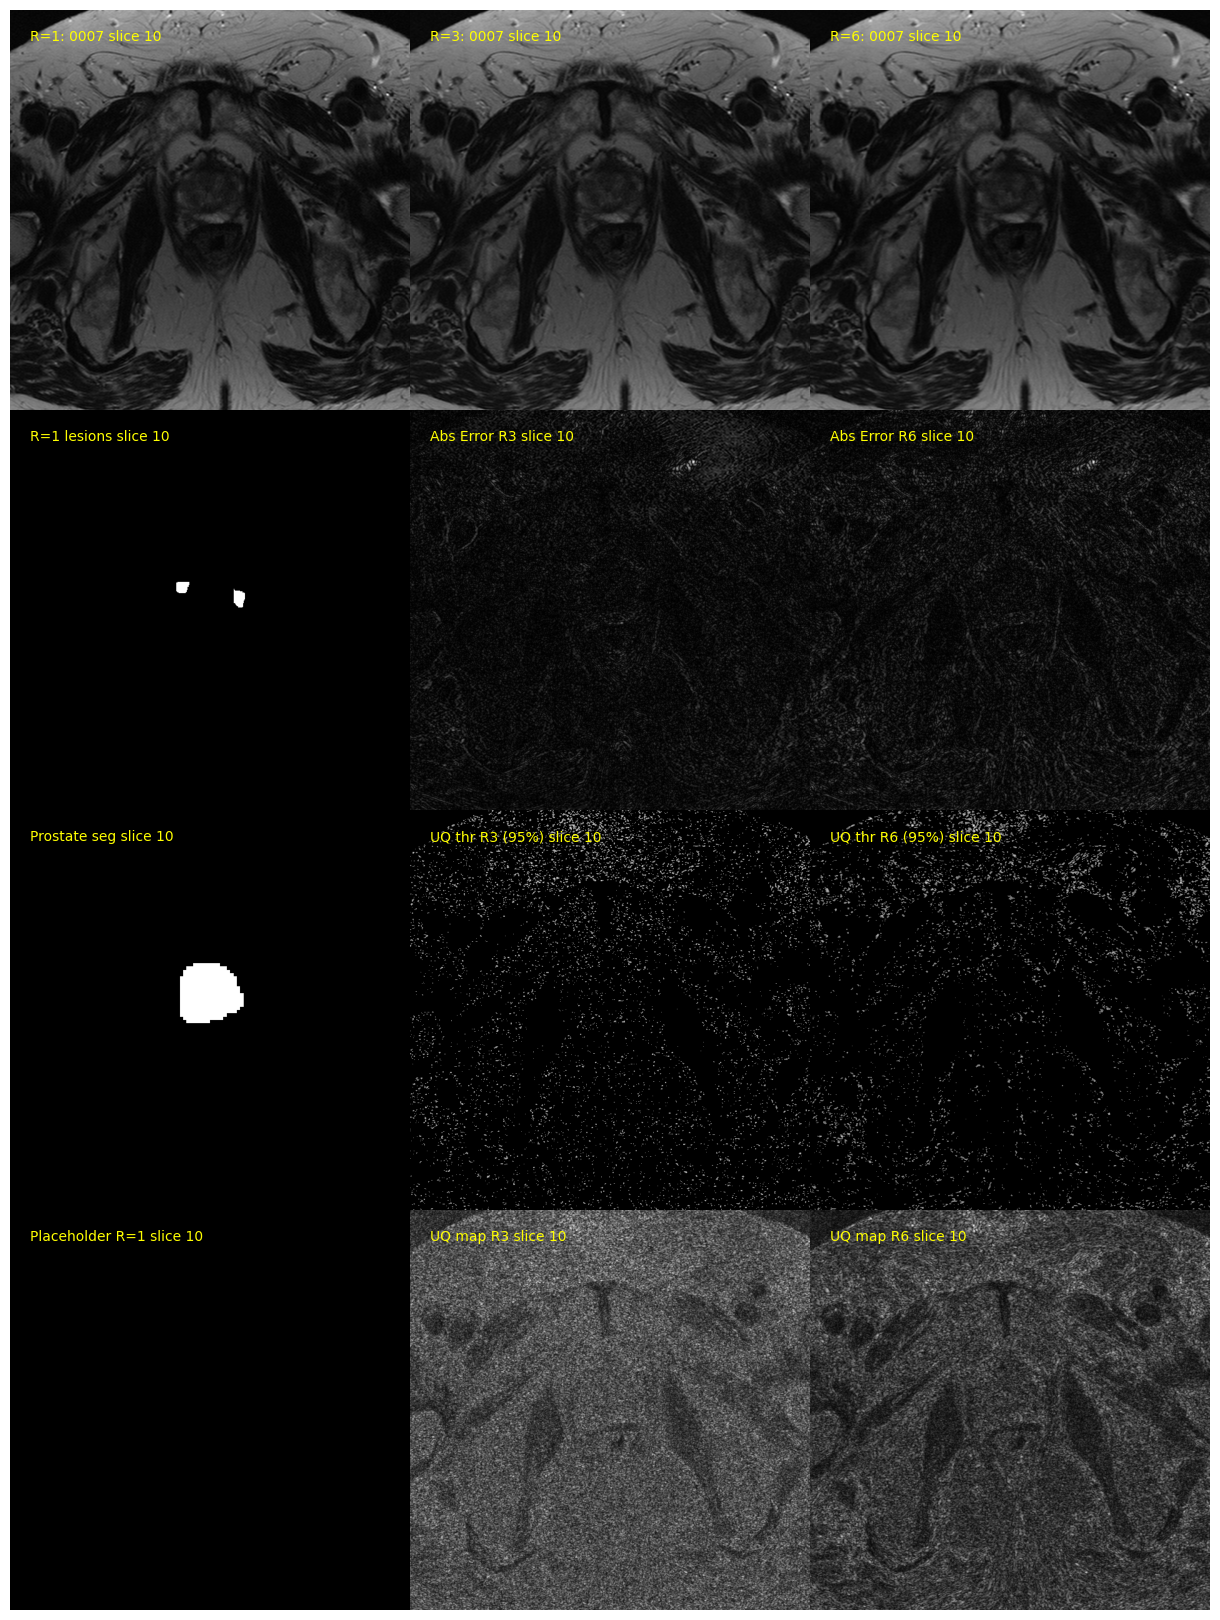

Figure saved to /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/figures/0007_ANON1586301_UQ_vs_ABS_slice10_R1_R3_R6.png


In [ ]:
def plot_uq_vs_abs_grid(
    pat_id: str,
    slice_idx: int,
    perc_thr: int,
    roots: Dict[Union[str, int], Path],
    save_dir: Path = Path('/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/figures')
):
    def get_combined_rois_array(pat_root: Path, r1_ref_image: sitk.Image, r1_arr: np.ndarray) -> Tuple[np.ndarray, List[int]]:
        roi_fpaths = list(pat_root.glob("*_roi_*.mha"))
        roi_arrs_combined = np.zeros_like(r1_arr)
        for roi_fpath in roi_fpaths:
            roi_img = sitk.ReadImage(str(roi_fpath))
            roi_img_resampled = resample_to_reference(roi_img, r1_ref_image)
            roi_arr = sitk.GetArrayFromImage(roi_img_resampled)
            roi_arrs_combined += roi_arr
            slice_idxs_lesion = [i for i in range(len(roi_arrs_combined)) if np.sum(roi_arrs_combined[i]) > 0]
            print(f"ROI {roi_fpath.name} has {len(slice_idxs_lesion)} slices with lesions. With idxs: {slice_idxs_lesion}")
        return roi_arrs_combined, slice_idxs_lesion

    pat_root          = roots['reader_study'] / pat_id
    r1_img            = sitk.ReadImage(str(pat_root / f"{pat_id}_rss_target_dcml.mha"))
    r1_arr            = sitk.GetArrayFromImage(r1_img)
    roi_arr, les_idxs = get_combined_rois_array(pat_root, r1_img, r1_arr)
    r1_empty_arr      = np.zeros_like(r1_arr)

    prostate_seg_root = roots['reader_study_segs'] / f"{pat_id}_mlseg_total_mr.nii.gz"
    prost_seg_arr     = sitk.GetArrayFromImage(sitk.ReadImage(str(prostate_seg_root))) # so this is a segmentation of many multi-label anatomical structures, where are interested in where it is the prostate=17
    prost_seg_arr     = np.where(prost_seg_arr == 17, 1, 0) # this is the prostate segmentation

    r3_arr            = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R3_recon_dcml.mha")))
    r3_abs_error_arr  = np.abs(r1_arr - r3_arr)
    r3_uq_map_arr     = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R3_gaussian"] / pat_id / f"uq_map_R3_gm25.nii.gz")))
    r3_uq_thr         = apply_percentile_threshold(r3_uq_map_arr, percentile=perc_thr, debug=False)

    r6_arr            = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R6_recon_dcml.mha")))
    r6_abs_error_arr  = np.abs(r1_arr - r6_arr)
    r6_uq_map_arr     = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R6_gaussian"] / pat_id / f"uq_map_R6_gm25.nii.gz")))
    # r6_uq_map_arr_blu = apply_gaussian_blur_3d(r6_uq_map_arr, sigma_xy=1.0, sigma_z=0.0)
    r6_uq_thr         = apply_percentile_threshold(r6_uq_map_arr, percentile=perc_thr, debug=False)

    fig, axs = plt.subplots(4, 3, figsize=(12, 16))
    seq_id = pat_id.split('_')[0]

    grid = [
        [r1_arr,        r3_arr,           r6_arr],
        [roi_arr,       r3_abs_error_arr, r6_abs_error_arr],
        [prost_seg_arr, r3_uq_thr,        r6_uq_thr],
        [r1_empty_arr,  r3_uq_map_arr,    r6_uq_map_arr]
    ]
    titles = [
        [f"R=1: {seq_id}",  f"R=3: {seq_id}",           f"R=6: {seq_id}"],
        [f"R=1 lesions",    f"Abs Error R3",            f"Abs Error R6"],
        ["Prostate seg",    f"UQ thr R3 ({perc_thr}%)", f"UQ thr R6 ({perc_thr}%)"],
        ["Placeholder R=1", "UQ map R3",                "UQ map R6"]
    ]

    # If there are no lesions, use the slice index provided
    # slice_idx = slice_idx if len(les_idxs) == 0 else les_idxs[0]
    print(f"Using slice index {slice_idx} for patient {pat_id}")

    for i in range(4):
        for j in range(3):
            axs[i, j].imshow(grid[i][j][slice_idx], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].text(0.05, 0.95, f"{titles[i][j]} slice {slice_idx}", color='yellow', fontsize=10, transform=axs[i, j].transAxes, va='top')

    plt.tight_layout(pad=0)
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)

    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f"{pat_id}_UQ_vs_ABS_slice{slice_idx}_R1_R3_R6.png"
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)
    print(f"Figure saved to {save_path}")


plot_uq_vs_abs_grid(
    pat_id='0007_ANON1586301',
    slice_idx=10,
    perc_thr=95,
    roots=roots
)

In [6]:
pat_id = '0007_ANON1586301'

prostate_seg_root = roots['reader_study_segs'] / f"{pat_id}_mlseg_total_mr.nii.gz"
prostate_seg_img  = sitk.ReadImage(str(prostate_seg_root))
prost_seg_arr  = sitk.GetArrayFromImage(prostate_seg_img) # so this is a segmentation of many multi-label anatomical structures, where are interested in where it is the prostate=17
prost_seg_arr  = np.where(prost_seg_arr == 17, 1, 0) # this is the prostate segmentation

# for slice_idx in range(0, prost_seg_arr.shape[0]):
#     print(f"Slice {slice_idx} has {np.sum(prost_seg_arr[slice_idx])} prostate voxels")
#     # viusalize with matplotlib
#     plt.imshow(prost_seg_arr[slice_idx], cmap='gray')
#     plt.axis('off')
#     plt.title(f"Prostate segmentation for {pat_id}")
#     plt.show()
#     plt.close()

# see a histogram of the Uncertainty map

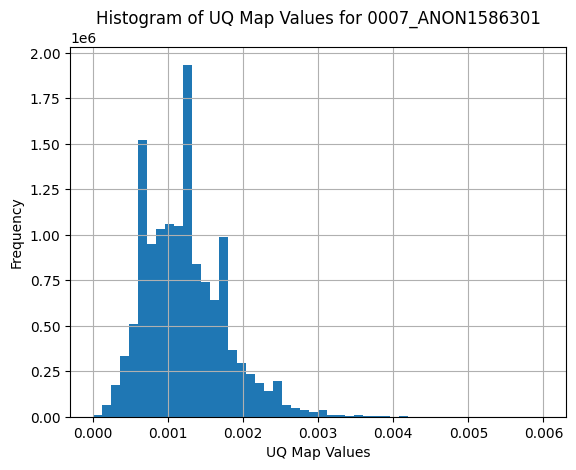

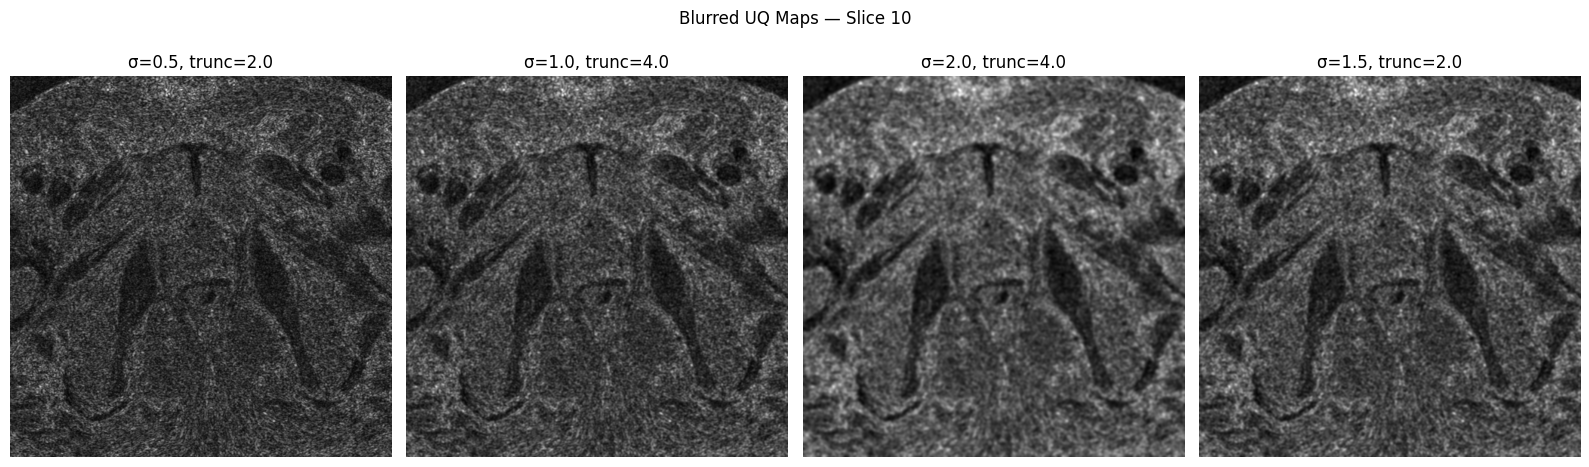

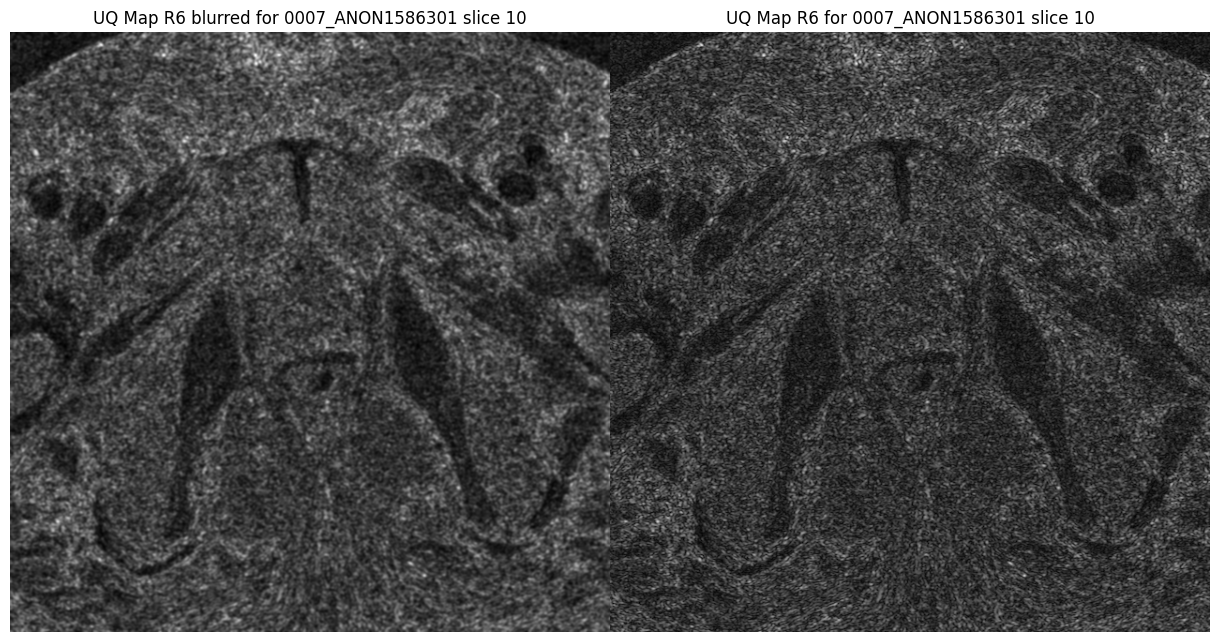

In [ ]:
def compare_gaussian_blur_settings(volume: np.ndarray, slice_idx: int, sigma_z: float = 0.0):
    """
    Compare multiple Gaussian blur parameter settings on a single slice.

    Parameters:
        volume (np.ndarray): 3D volume (slices, H, W)
        slice_idx (int): Index of slice to visualize
        sigma_z (float): Fixed sigma for through-plane blurring (usually 0)

    Returns:
        None (plots figure)
    """
    from scipy.ndimage import gaussian_filter
    import matplotlib.pyplot as plt

    # Define settings: (sigma_xy, truncate)
    settings = [
        (0.5, 2.0),   # Light blur, tight kernel
        (1.0, 4.0),   # Moderate blur, full kernel (default behavior)
        (2.0, 4.0),   # Stronger blur
        (1.5, 2.0),   # Medium sigma, compact kernel (local structure)
    ]

    fig, axs = plt.subplots(1, len(settings), figsize=(16, 5))
    for i, (sigma_xy, truncate) in enumerate(settings):
        blurred = gaussian_filter(volume, sigma=(sigma_z, sigma_xy, sigma_xy), truncate=truncate)
        axs[i].imshow(blurred[slice_idx], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"σ={sigma_xy}, trunc={truncate}")

    plt.suptitle(f"Blurred UQ Maps — Slice {slice_idx}")
    plt.tight_layout()
    plt.show()



pat_id        = '0007_ANON1586301'
slice_idx     = 10
pat_root      = roots['reader_study'] / pat_id
r6_arr        = sitk.GetArrayFromImage(sitk.ReadImage(str(pat_root / f"{pat_id}_VSharp_R6_recon_dcml.mha")))
r6_uq_map_arr = sitk.GetArrayFromImage(sitk.ReadImage(str(roots["R6_gaussian"] / pat_id / f"uq_map_R6_gm25.nii.gz")))

# lets see a histogram of the uq map with high resolution in binning
plt.hist(r6_uq_map_arr.flatten(), bins=50)
plt.xlabel("UQ Map Values")
plt.ylabel("Frequency")
plt.title(f"Histogram of UQ Map Values for {pat_id}")
plt.grid()
plt.show()

r6_uq_map_arr_blu = apply_gaussian_blur_3d(r6_uq_map_arr, sigma_xy=1.0, sigma_z=0.0)
compare_gaussian_blur_settings(r6_uq_map_arr, slice_idx=10)


# lets visualize the uq map and the blurred uq map next to each other tightly
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(r6_uq_map_arr_blu[slice_idx], cmap='gray')
axs[0].axis('off')
axs[0].set_title(f"UQ Map R6 blurred for {pat_id} slice {slice_idx}")
axs[1].imshow(r6_uq_map_arr[slice_idx], cmap='gray')
axs[1].axis('off')
axs[1].set_title(f"UQ Map R6 for {pat_id} slice {slice_idx}")
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
plt.show()
